# Implementing an autoencoder for ATLAS 

An autoencoder neural network was used to compress the four-momentum of a sample of simulated particles from 4 to 3 variables.

This was an evaluation task by the maintainers of the ATLAS project at CERN.

In [13]:
import sys
sys.version

'3.8.5 (default, Jan 27 2021, 15:41:15) \n[GCC 9.3.0]'

## Importing the dataset and 'cleaning' the data

Two interesting properties of the given CSV file:
1. Empty fields are not specified by separators at the end of the line.
2. Two kinds of delimiters used - semicolon (;) and comma (,).

Both the issues were ironed out using python's built-in CSV engine. To avoid typecasting every field, a new 'clean' CSV file was created, which was imported using pandas and hence, all the fields were allocated appropriate data types by pandas automatically.

In [14]:
import csv

temp_data = []
d = []

with open('dataset.csv') as csvfile:
    # Here, lines are split by semicolon
    areader = csv.reader(csvfile, delimiter = ';')
    
    # This code splits the fields that contain a comma
    for row in areader:
        temp = list()
        for element in row:
            if ',' in element:
                a = element.split(',')
                temp = temp+a
            else:
                temp.append(element)
        temp_data.append(temp)
                
    # Find out max no. of columns
    max_elems = 0
    for row in temp_data:
        if max_elems < len(row):
            max_elems = len(row)
        
    csvfile.seek(0)
    
    # Add separators for empty fields by padding the rows
    for i, row in enumerate(temp_data):         
        d.append(row + ["" for x in range(max_elems-len(row))])

# Write to a new CSV file
with open ('new_dataset.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(d)

In [15]:
import pandas as pd
temp_df = pd.read_csv('new_dataset.csv', header=None)
temp_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,354,monojet_Zp2000.0_DM_50.0,0.000024,832841.0,-1.224310,b,947383.0,824498.0,-0.523103,1.644210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,354,monojet_Zp2000.0_DM_50.0,0.000024,732115.0,1.172450,j,1069460.0,751597.0,0.858186,-1.842170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,354,monojet_Zp2000.0_DM_50.0,0.000024,1056280.0,-3.067440,j,676000.0,640429.0,0.330450,0.704554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,354,monojet_Zp2000.0_DM_50.0,0.000024,631781.0,1.641810,j,936707.0,616229.0,0.973383,-1.565920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,354,monojet_Zp2000.0_DM_50.0,0.000024,457316.0,-1.875360,j,640313.0,589524.0,0.390749,1.237340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6394,354,monojet_Zp2000.0_DM_50.0,0.000024,914355.0,1.529030,j,1119940.0,1012690.0,0.453265,-1.772780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6395,354,monojet_Zp2000.0_DM_50.0,0.000024,782256.0,-1.207510,j,1915090.0,874869.0,1.418550,1.839270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6396,354,monojet_Zp2000.0_DM_50.0,0.000024,645619.0,-2.483990,j,787964.0,263158.0,1.759810,0.456786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6397,354,monojet_Zp2000.0_DM_50.0,0.000024,632390.0,-0.975687,j,731849.0,722541.0,-0.134499,2.563930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Obtaining relevant data from the dataset

From the dataset, we can disregard the first five columns, which correspond to the event details. Beginning from the sixth column, we see a set of 5 fields that correspond to the type of object and its four momentum. There are in total 65 fields, which implies that an event may have resulted in up to 12 objects to be detected.

Our aim is to work on the four momentum of only jet object (id='j'). To do that we create an empty dataframe of four columns (E, pt, eta, phi), which will be used to note down the values of the four momentum. We begin by looking for jet objects in every object detected for all events. For every jet object that is found, we add the values of its four momentum to the dataframe we created.

In [16]:
df = pd.DataFrame(columns = ['E','pt','eta','phi'])
count = 0
for l in range(len(temp_df)):
    for i in range(5,61,5):
        if temp_df.iloc[l,i] == 'j':
            df.loc[count] = [temp_df.iloc[l,i+1],temp_df.iloc[l,i+2],temp_df.iloc[l,i+3],temp_df.iloc[l,i+4]]
            count += 1

In [17]:
for i in df:
    print("Column name: "+str(i))
    print("Max: "+str(max(df[i])))
    print("Min: "+str(min(df[i])))
    print("\n")

Column name: E
Max: 4413680.0
Min: 24375.8


Column name: pt
Max: 2090860.0
Min: 22086.5


Column name: eta
Max: 4.75308
Min: -4.87011


Column name: phi
Max: 3.14121
Min: -3.14156




We can see that the columns 'E' and 'pt' have data ranging from 10^5 to 10^7 while columns 'eta' and 'phi' have data ranging from 10^0 to 10^1. To make sure that our model trains well, we need to make sure the range of all our columns are close. Hence, we will divide columns 'E' and 'pt' by 10^5 and change their names to describe the conversion.

In [18]:
df['E'] = df['E']/100000
df['pt'] = df['pt']/100000
df.rename(columns={"E": "E (10^5)", "pt": "pt (10^5)"}, inplace = True)
df

,E (10^5),pt (10^5),eta,phi
0,2.587220,2.436750,0.328962,2.250140
1,5.200920,1.085900,-2.247300,-1.856790
2,3.830240,0.884056,2.145160,-1.956350
3,0.395076,0.353651,0.470460,-1.164450
4,2.254300,0.268782,-2.816080,-2.259380
...,...,...,...,...
22656,7.318490,7.225410,-0.134499,2.563930
22657,2.688280,2.591440,0.153813,0.578428
22658,1.533400,0.439315,1.920140,-0.237382
22659,8.936890,7.420400,-0.618057,-3.104660


## Describing data for training and validating the model

We will now be splitting the data into a 75:25 ratio for training and validation. The data used for training has been plotted then.

In [19]:
# Splitting data into training and validation of ratio 75:25 randomly.
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25)

In [20]:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
       E (10^5)  pt (10^5)       eta       phi
12860   1.26219   1.247560  0.111721  1.299460
10728   3.91716   3.837960 -0.086613 -0.071681
14385   6.10849   5.499000 -0.395276 -2.526780
10358   3.39384   3.271810 -0.160354 -2.257660
8274    1.74903   0.929681 -1.240990 -2.094720


Testing sample:
       E (10^5)  pt (10^5)       eta      phi
19554  9.683960   3.392530  1.709130  1.65616
13820  0.847911   0.543161 -0.999728  2.33495
5480   4.950340   0.342785 -3.361950 -2.68709
16698  1.831900   1.752810  0.232896 -2.97723
11113  7.674470   7.570360 -0.148339 -1.56063


The number of entries in the training data: 16995
The number of entries in the validation data: 5666


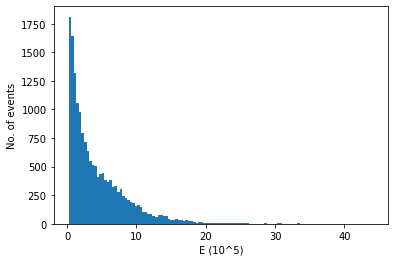

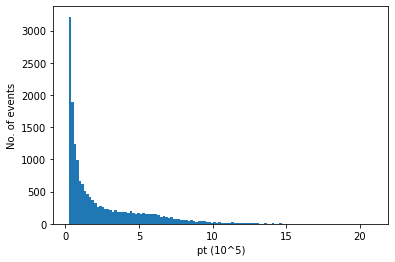

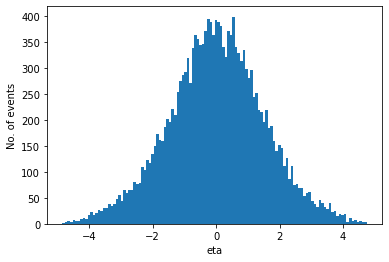

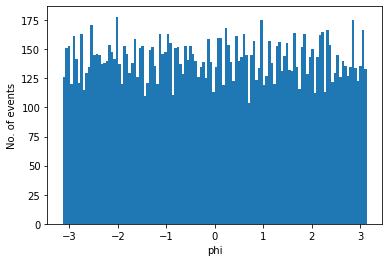

In [21]:
# Plotting the training data
import matplotlib.pyplot as plt

branches=["E (10^5)","pt (10^5)","eta","phi"]

n_bins = 120

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=branches[kk])
    plt.ylabel('No. of events')
    plt.show()

## Preparing data for use with fastai

Tensor objects are created for training and validation. pyTorch's DataLoader is used to define batch sizes for both these objects. These objects are then loaded into a fastai object, which will now be used on our model.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


train_x = train
test_x = test

# Since output = input, y = x
train_y = train_x 
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [23]:
from fastai import learner
from fastai.data import core

bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

## Describing the model of the neural network

The neural network described in the example notebook (LeakyReLU with 200-20-3-20-200 architecture and a tanh activation function) will be used here as well.

In [24]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

## Defining performance metrics

To compute the loss, we use mean-squared-error (MSE) as a metric.

In [25]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

wd = 1e-4

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

The lr_find module of fastai is used to find optimum values of the learning rate.

Learning rate with the minimum loss: 0.0030902953818440436
Learning rate with the steepest gradient: 7.943282298583654e-07


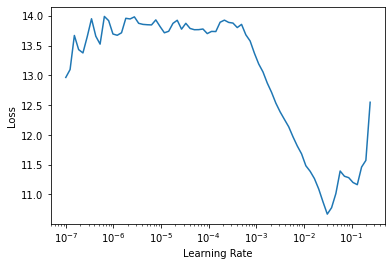

In [26]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find(end_lr = 100)

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

## Training and testing the model

The epoch has been set to 100 and the learning rate has been set to lr_min as obtained from fastai's lr_find function. 

In [27]:
# Using lr_min as learning rate
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100, lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 10.235069274902344, 8.10090446472168, '00:00']
[0, 10.235069274902344, 8.10090446472168, '00:00']
[1, 6.414185523986816, 3.9707717895507812, '00:00']
[1, 6.414185523986816, 3.9707717895507812, '00:00']
[2, 3.580148935317993, 2.091618776321411, '00:00']
[2, 3.580148935317993, 2.091618776321411, '00:00']
[3, 2.0828440189361572, 1.3586995601654053, '00:00']
[3, 2.0828440189361572, 1.3586995601654053, '00:00']
[4, 1.3340851068496704, 0.9971200227737427, '00:00']
[4, 1.3340851068496704, 0.9971200227737427, '00:00']
[5, 0.9889674782752991, 0.8104299902915955, '00:00']
[5, 0.9889674782752991, 0.8104299902915955, '00:00']
[6, 0.747494637966156, 0.5484955906867981, '00:00']
[6, 0.747494637966156, 0.5484955906867981, '00:00']
[7, 0.47510772943496704, 0.3032650053501129, '00:00']
[7, 0.47510772943496704, 0.3032650053501129, '00:00']
[8, 0.2786039113998413, 0.15913408994674683, '00:00']
[8, 0.2786039113998413, 0.15913408994674683, '00:00']
[9, 0.1535506695508957, 0.09618393331766129, '00:00']


[73, 0.0025087406393140554, 0.0026123900897800922, '00:00']
[73, 0.0025087406393140554, 0.0026123900897800922, '00:00']
[74, 0.0021376253571361303, 0.0027129752561450005, '00:00']
[74, 0.0021376253571361303, 0.0027129752561450005, '00:00']
[75, 0.0020338832400739193, 0.0024819315876811743, '00:00']
[75, 0.0020338832400739193, 0.0024819315876811743, '00:00']
[76, 0.0024531856179237366, 0.0027326063718646765, '00:00']
[76, 0.0024531856179237366, 0.0027326063718646765, '00:00']
[77, 0.0018023466691374779, 0.0016368087381124496, '00:00']
[77, 0.0018023466691374779, 0.0016368087381124496, '00:00']
[78, 0.0012845443561673164, 0.002091116737574339, '00:00']
[78, 0.0012845443561673164, 0.002091116737574339, '00:00']
[79, 0.0012429978232830763, 0.001683094073086977, '00:00']
[79, 0.0012429978232830763, 0.001683094073086977, '00:00']
[80, 0.0011620746226981282, 0.0013638766249641776, '00:00']
[80, 0.0011620746226981282, 0.0013638766249641776, '00:00']
[81, 0.00109263660851866, 0.0014716711593791

Here is a depiction of the loss function as it progresses through the batches and epochs of the training dataset and validates the model.

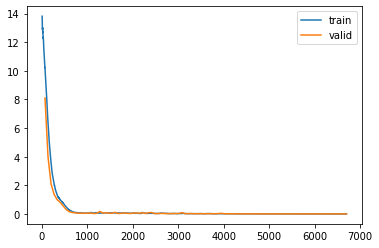

In [28]:
recorder.plot_loss()

Finally, we compute the MSE loss.

In [29]:
learn.validate()

(#1) [0.000772654777392745]

0.08% - that should be good enough.

## Plotting data

Setting directory for saving outputs.

In [30]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Plotting histograms of the training and validation for 20000 events.

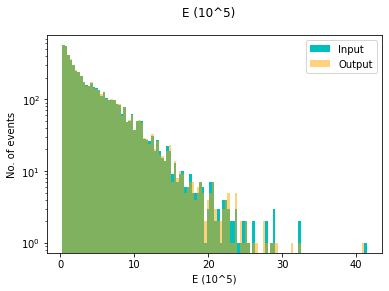

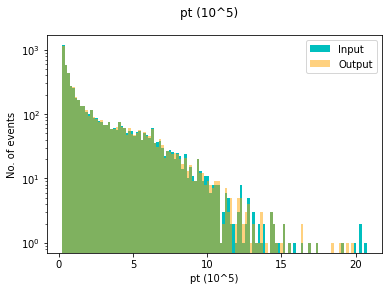

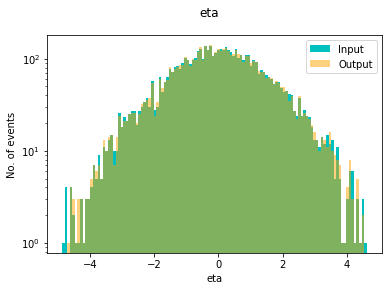

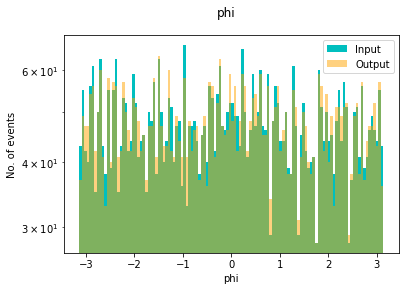

In [59]:
import numpy as np

plt.close('all')
line_style = ['--', '-']
markers = ['*', 's']

model.to('cpu')

save = True

# Histograms
idxs = (0, 20000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)   

n_bins = 120
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color='c', label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color='orange', label='Output', alpha=0.5, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('No. of events')
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

